for colab

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

## 1. Data preparation

Connecting gdrive (to get weights)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Downloading train data

In [ ]:
! mkdir -p datasets/vedai

In [ ]:
%cd datasets/vedai

/content/datasets/vedai


In [ ]:
! curl -L "https://app.roboflow.com/ds/uA01dQpo7f?key=JWDkBmQc6N" > roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   2128      0 --:--:-- --:--:-- --:--:--  2123
100  427M  100  427M    0     0  64.0M      0  0:00:06  0:00:06 --:--:-- 73.0M


In [ ]:
! unzip roboflow.zip

In [ ]:
! rm roboflow.zip

We have an issue with data.yaml - incorrect path to images

In [ ]:
with open("/content/datasets/vedai/data.yaml", "r+") as f:
  old = f.read().replace("../train/images", "/content/datasets/vedai/train/images")
  new = old.replace("../valid/images", "/content/datasets/vedai/valid/images")
  f.seek(0)
  f.write(new)

In [ ]:
%cd /content

/content


## 2. Training the model

Installing yolov5

In [ ]:
! git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12164, done.
remote: Total 12164 (delta 0), reused 0 (delta 0), pack-reused 12164
Receiving objects: 100% (12164/12164), 11.89 MiB | 26.88 MiB/s, done.
Resolving deltas: 100% (8425/8425), done.


In [ ]:
%cd /content/yolov5
! pip install -r requirements.txt

Installing wandb (for tracking experiments)

In [ ]:
! pip install wandb

login to wandb

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

We may have to strip the optimizer (sometimes pretrained model could be not ready to use)

In [ ]:
# from utils.general import *; strip_optimizer("/content/gdrive/MyDrive/weights/yolov5s_visdrone/exp/weights/best.pt")

Optimizer stripped from /content/gdrive/MyDrive/weights/yolov5s_visdrone/exp/weights/best.pt, 14.5MB


Training the model with following parameters:

*   Adam optimizer
*   Learning rate: 3*10^(-4) & cosine schedule of lr
*   Epochs: 65
*   Max batch size (to avoid problems with BatchNorm)
*   Image size 900p (as in pretrained model)
*   Freezed last 3 layers



In [ ]:
! python train.py --resume "/content/gdrive/MyDrive/weights/yolov5s_vedai/exp11/weights/last.pt"

In [ ]:
# ! python train.py --data "/content/datasets/vedai/data.yaml" --hyp "/content/gdrive/MyDrive/weights/yolov5s_vedai/cfg/hyp.yaml" --weights "/content/gdrive/MyDrive/weights/yolov5s_visdrone/exp/weights/best.pt" --epochs 65 --batch-size -1 --imgsz 900 --optimizer Adam --cos-lr --freeze 3 --project "/content/gdrive/MyDrive/weights/yolov5s_vedai"

Inference

In [ ]:
! python detect.py --weights "/content/gdrive/MyDrive/weights/yolov5s_vedai/exp11/weights/best.pt" --conf 0.2 --source '/content/datasets/vedai/valid/images'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random


def img_reshape(img):
    img = Image.open(img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

In [ ]:
def image_grid(array, ncols=4):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    
    return img_grid

In [ ]:
path = '/content/yolov5/runs/detect/exp2'
images = [os.path.join(path, random.choice(os.listdir(path))) for _ in range(8)]

img_arr = [img_reshape(_) for _ in images]

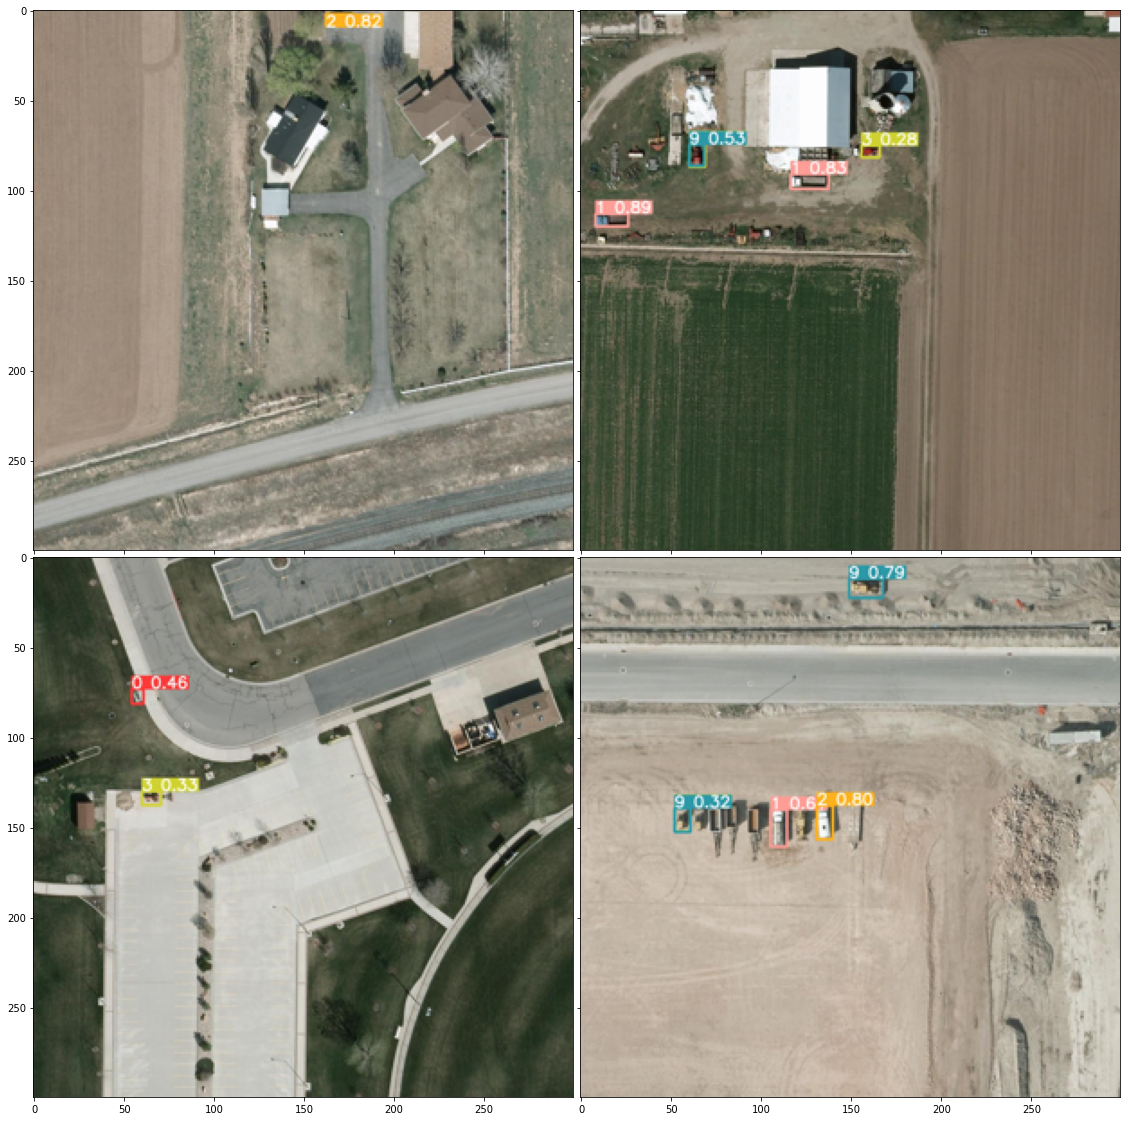

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()